In [1]:
import os, sys, time
import numpy as np
from scipy.interpolate import RectBivariateSpline
from sklearn.metrics.pairwise import euclidean_distances

import matplotlib.pylab as plt




sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/LibFolder")
sys.path.insert(0,"/home/nico/Documents/TEAR/Codes_TEAR/se2dr/se2wave/utils/python")
from se2waveload import *
from Lib_GeneralFunctions import *

from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
# Sigmoid or any function of interest to represent the center of the fault / Zero level set function
def func(x, k=-0.0002, amp = 2.0):
    fx = amp * (x - x * k) / (k - abs(x) * 2.0 * k + 1.0)
    return fx

# The respective derivative ofthe previous zero level set function
def func_der(x, k=-0.0002, amp = 2.0):
    fx_prime = amp * (1 - k * k) / ((k - abs(x) * 2.0 * k + 1.0)*(k - abs(x) * 2.0 * k + 1.0))
    return fx_prime


# Tangent vector for a given derivative
def TangentVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    TangentX = 1.0/mag
    TangentY = fPrimeX/mag
    return TangentX, TangentY

# Normal vector for a given derivative
def NormalVector(fPrimeX, **kwargs):
    mag = np.sqrt(1.0 + fPrimeX * fPrimeX)
    
    NormalX = -fPrimeX/mag
    NormalY = 1.0/mag
    
    return NormalX, NormalY



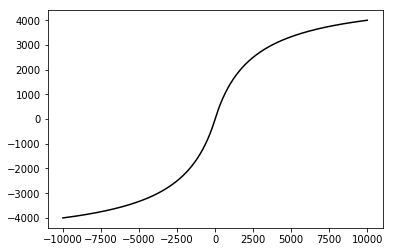

In [3]:
#Test
plt.figure()
xx = np.linspace(-1.e4, 1.e4, 6001)
plt.plot(xx,func(xx),"k-")

In [4]:
xx[3000]

0.0

In [5]:
def SeparateList(List2Sep,nx,ny):
    TotNum = len(List2Sep)
    xComponent = List2Sep[0:TotNum:2]
    yComponent = List2Sep[1:TotNum:2]

    xComponent = np.reshape(xComponent, (nx, ny), "F")
    yComponent = np.reshape(yComponent, (nx, ny), "F")
    return xComponent,yComponent


def ExtractFields(w_filename, se2_coor):
    se2_field = se2wave_load_wavefield(w_filename,True,True)
    TimeStep = se2_field["time"].item()

    LCoorX, LCoorY         = SeparateList(se2_coor['coor'],   se2_coor['nx'].item(),  se2_coor['ny'].item())
    LFieldX, LFieldY       = SeparateList(se2_field['displ'], se2_field['nx'].item(), se2_field['ny'].item())
    LFieldvelX, LFieldvelY = SeparateList(se2_field['vel'],   se2_field['nx'].item(), se2_field['ny'].item())
    
    return TimeStep, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY


def GetBivariateSplineFuncFromFields(LCoorX, LCoorY, LFieldX, LFieldY,LFieldvelX, LFieldvelY):
    SplineDispl = [RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldX, kx=1, ky=1), 
                   RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldY, kx=1, ky=1)]
    SplineVel = [RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldvelX, kx=1, ky=1), 
                 RectBivariateSpline(LCoorX[:,0], LCoorY[0,:], LFieldvelY, kx=1, ky=1)]
    
    return SplineDispl, SplineVel


def GetLocData(Loc, SplineFunction, GetSlip=False):

    CompX = SplineFunction[0](Loc[0],Loc[1])[0][0]
    CompY = SplineFunction[1](Loc[0],Loc[1])[0][0]
    return CompX, CompY


# Wrappers
def GetSplineFunctions(w_filename, se2_coor):
    TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(w_filename, se2_coor)
    SplineDisplPair, SplineVelPair = GetBivariateSplineFuncFromFields(LCoorX, LCoorY, 
                                                              LFieldX, LFieldY,
                                                              LFieldvelX, LFieldvelY)
    return TimeStepVal, SplineDisplPair, SplineVelPair

In [6]:
def PlotDomain(CoorX, CoorY, Field, FieldName,TimeTxt,**kwargs):
    try:
      fig = plt.figure(figsize = (10, 10), constrained_layout=True)
      gs = fig.add_gridspec(1, 1)
      ax = fig.add_subplot(gs[:, :])
    except:
      fig = plt.figure(figsize = (10, 10))
      ax = fig.add_subplot(1,1,1)
    ax.set_title("{FName}".format(FName = FieldName[0]))
    ax.set_xlabel("X-Coordinate [m]"), ax.set_ylabel("Y-Coordinate [m]")
    ax.set_aspect('equal', 'box')
    img = ax.pcolormesh(CoorX, CoorY, Field,**kwargs)

    ax.annotate(text="T:{0:.2f}s".format(TimeTxt),xy=[0.8,0.1], xycoords= "axes fraction")
    cbar = fig.colorbar(img, shrink=.5)
    cbar.ax.set_ylabel(FieldName[1])
    
    return fig, img,ax

In [7]:
from palettable.scientific.diverging import Roma_5 as ElColor

cmap = ElColor.mpl_colormap

In [8]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Desktop/EGU2021/SigmoidPlotP1/"


i=2250
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

In [9]:
TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

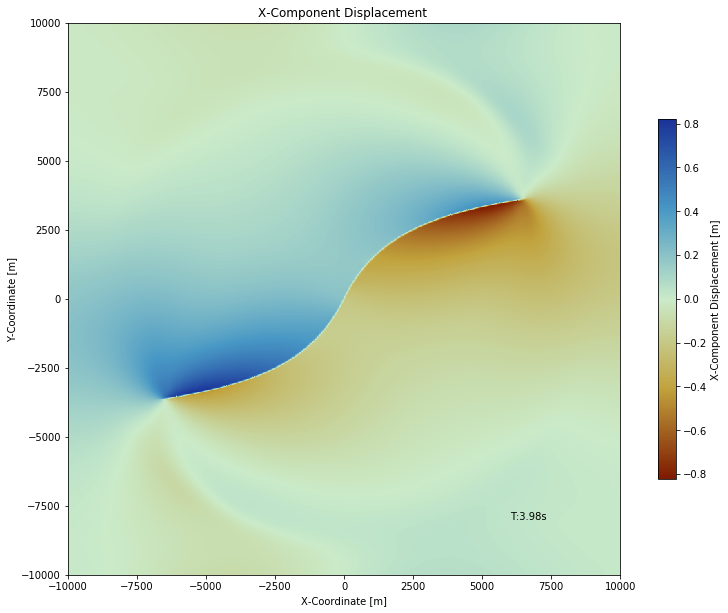

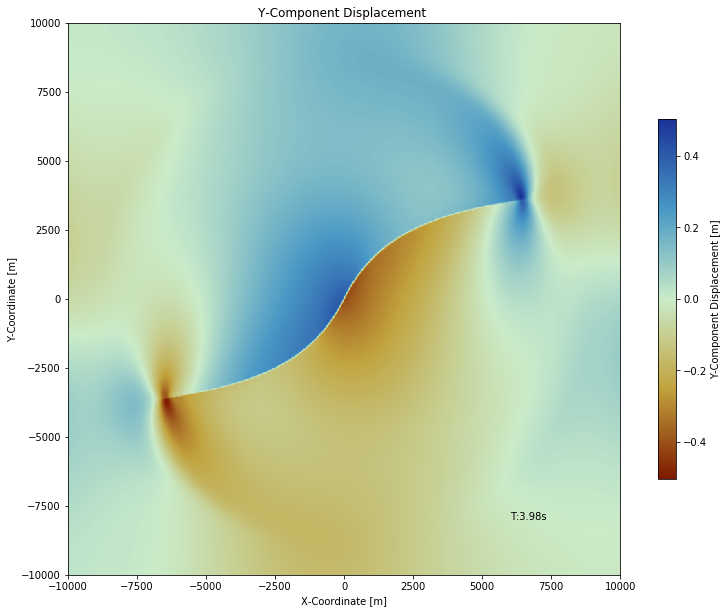

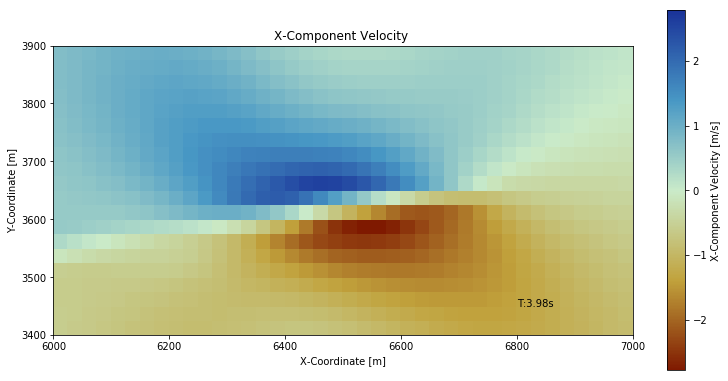

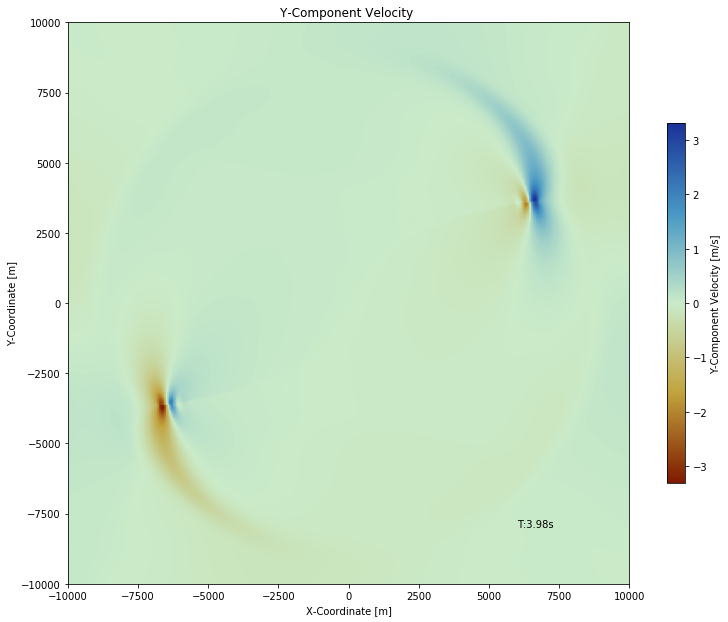

In [10]:
plt.rcParams["axes.axisbelow"] = False
F1,Im1,ax1 = PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F2,Im2,ax2 = PlotDomain(LCoorX, LCoorY, LFieldY, 
           ["Y-Component Displacement ", "Y-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F3,Im3,ax3 = PlotDomain(LCoorX, LCoorY, LFieldvelX, 
           ["X-Component Velocity ", "X-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
F4,Im4,ax4 = PlotDomain(LCoorX, LCoorY, LFieldvelY, 
           ["Y-Component Velocity ", "Y-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
ax3.set_ylim(3400,3900)
ax3.set_xlim(6000,7000)
ax3.grid(True, which='minor', axis='both', linestyle='-', color='k')

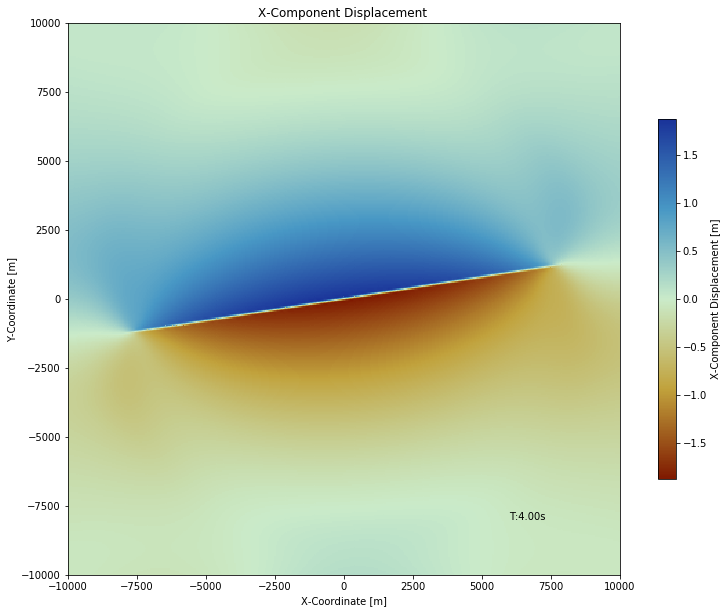

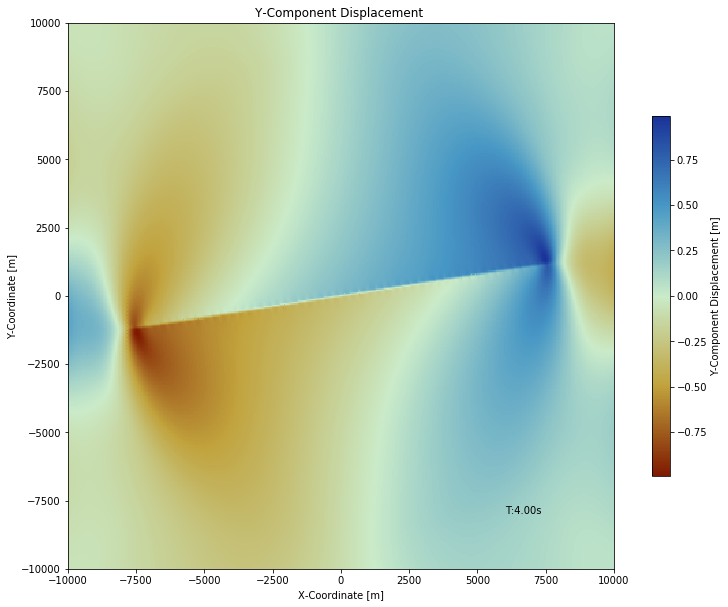

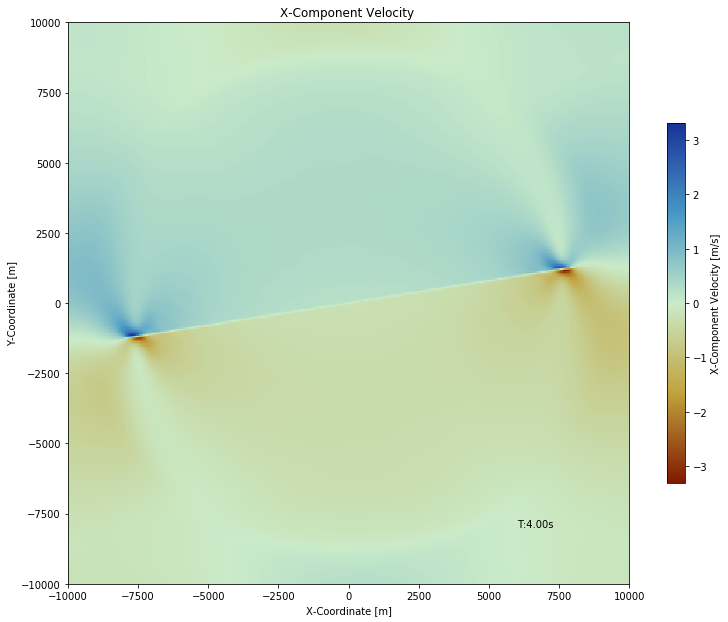

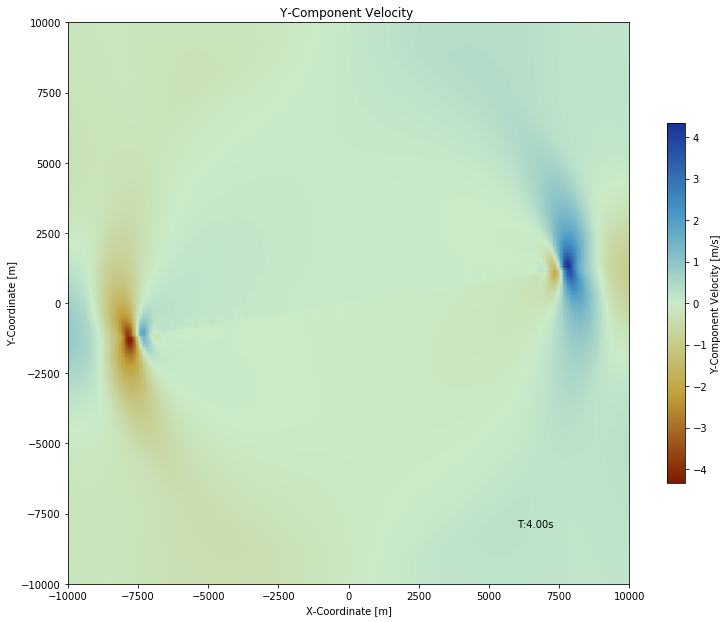

In [11]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/ConferencesFigures/EGU2021/TiltedData/09deg/"


i=1130
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

F1,Im1,ax1 = PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F2,Im2,ax2 = PlotDomain(LCoorX, LCoorY, LFieldY, 
           ["Y-Component Displacement ", "Y-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F3,Im3,ax3 = PlotDomain(LCoorX, LCoorY, LFieldvelX, 
           ["X-Component Velocity ", "X-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
F4,Im4,ax4 = PlotDomain(LCoorX, LCoorY, LFieldvelY, 
           ["Y-Component Velocity ", "Y-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)


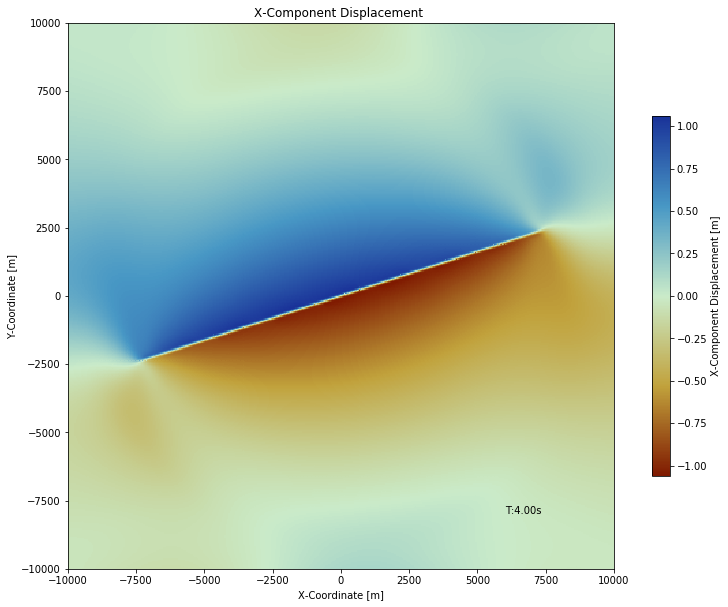

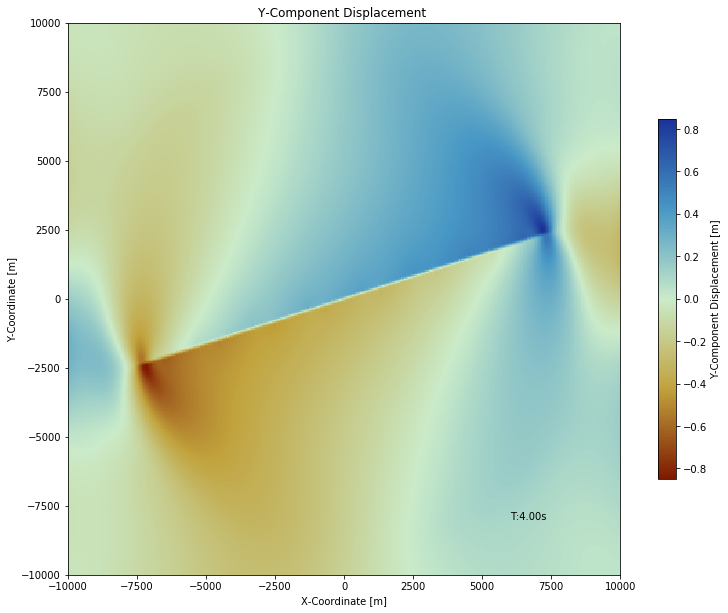

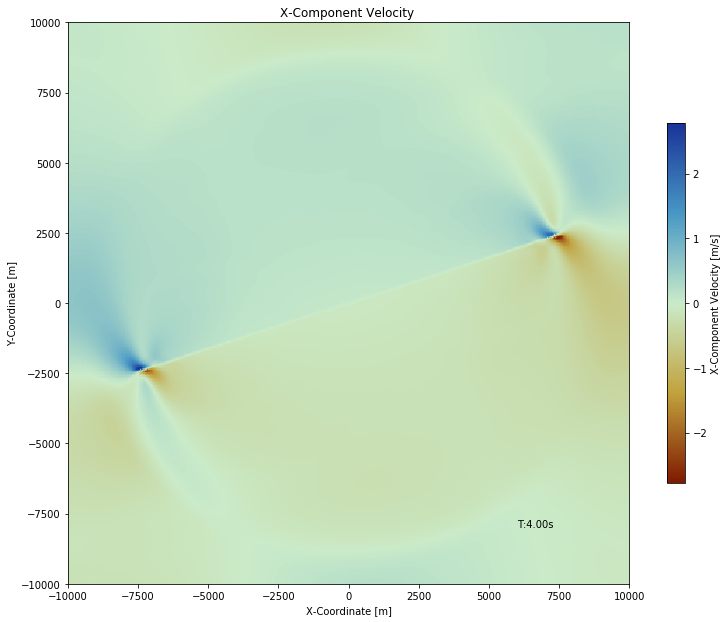

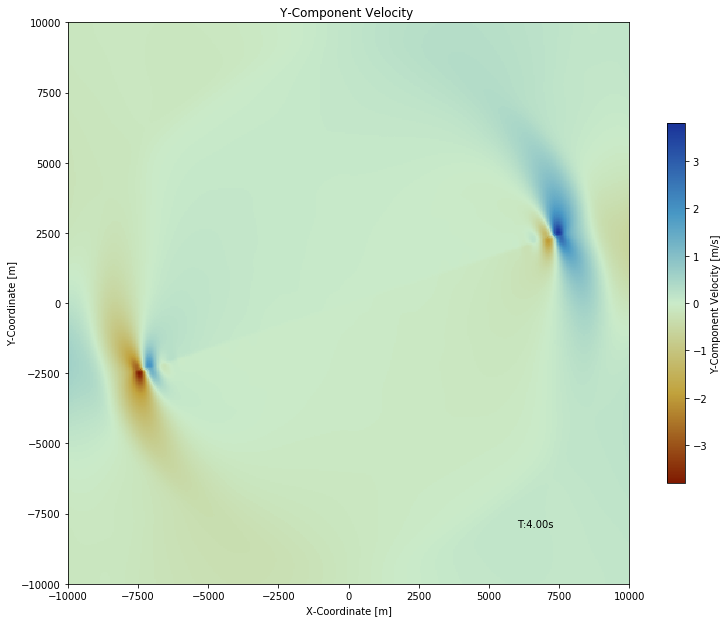

In [12]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/ConferencesFigures/EGU2021/TiltedData/18deg/"


i=1130
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

F1,Im1,ax1 = PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F2,Im2,ax2 = PlotDomain(LCoorX, LCoorY, LFieldY, 
           ["Y-Component Displacement ", "Y-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F3,Im3,ax3 = PlotDomain(LCoorX, LCoorY, LFieldvelX, 
           ["X-Component Velocity ", "X-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
F4,Im4,ax4 = PlotDomain(LCoorX, LCoorY, LFieldvelY, 
           ["Y-Component Velocity ", "Y-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)


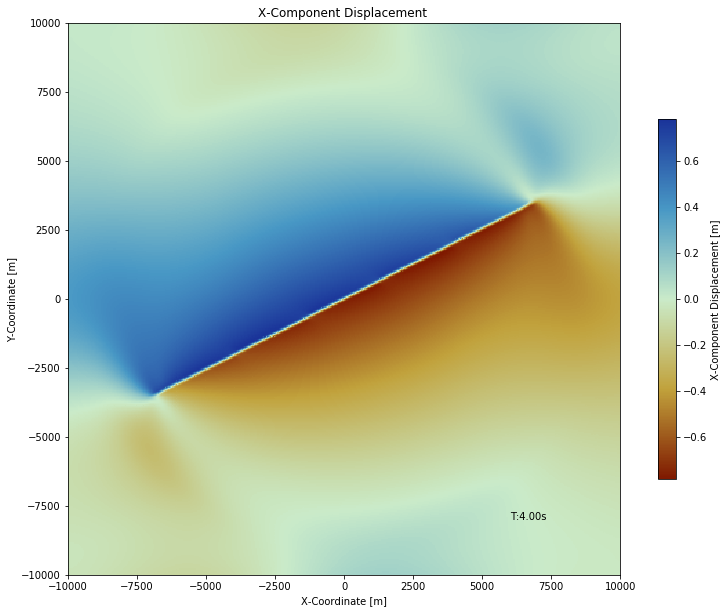

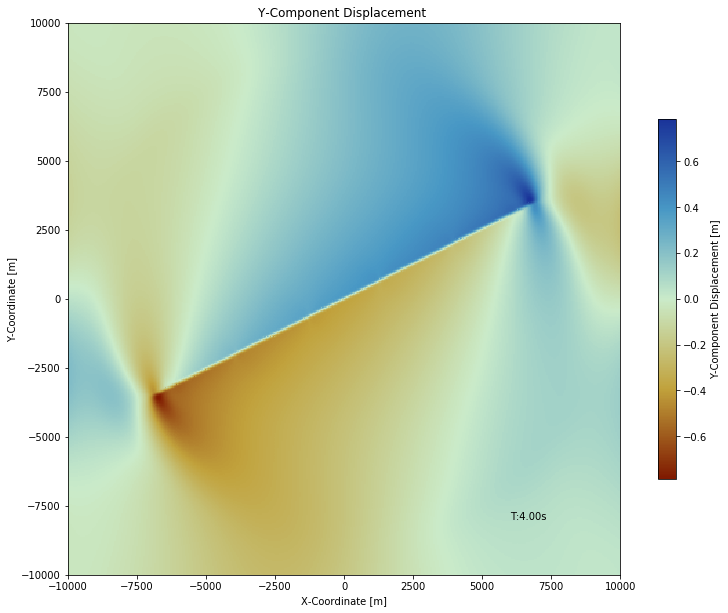

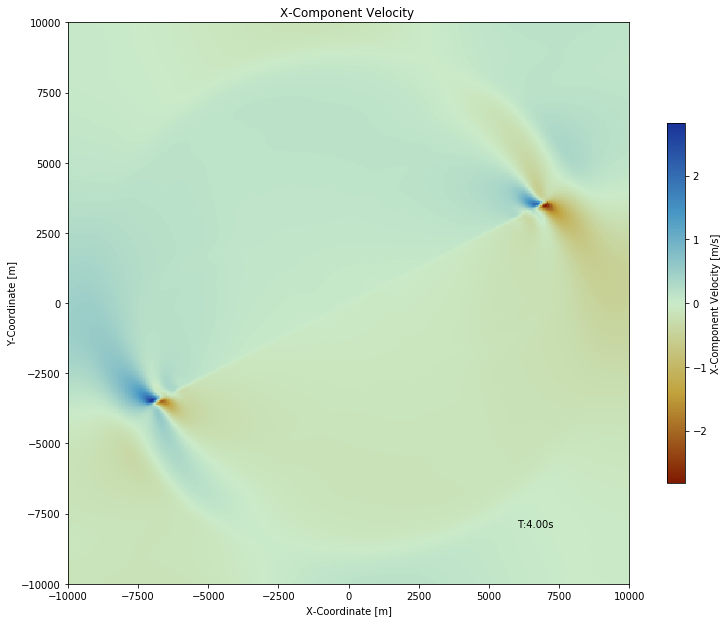

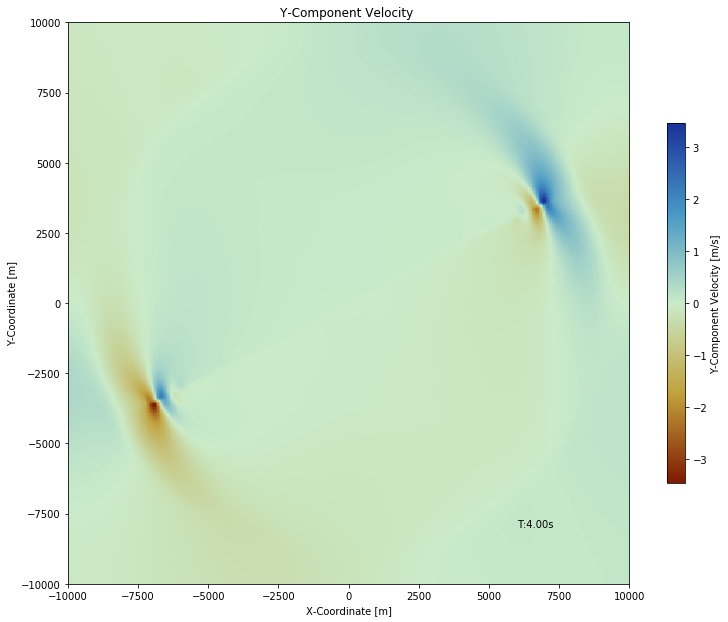

In [13]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/ConferencesFigures/EGU2021/TiltedData/27deg/"


i=1130
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

F1,Im1,ax1 = PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F2,Im2,ax2 = PlotDomain(LCoorX, LCoorY, LFieldY, 
           ["Y-Component Displacement ", "Y-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F3,Im3,ax3 = PlotDomain(LCoorX, LCoorY, LFieldvelX, 
           ["X-Component Velocity ", "X-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
F4,Im4,ax4 = PlotDomain(LCoorX, LCoorY, LFieldvelY, 
           ["Y-Component Velocity ", "Y-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)


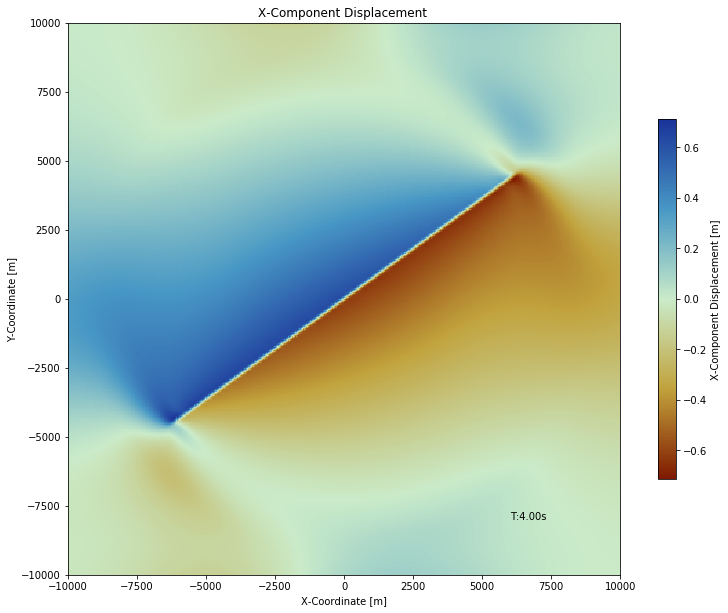

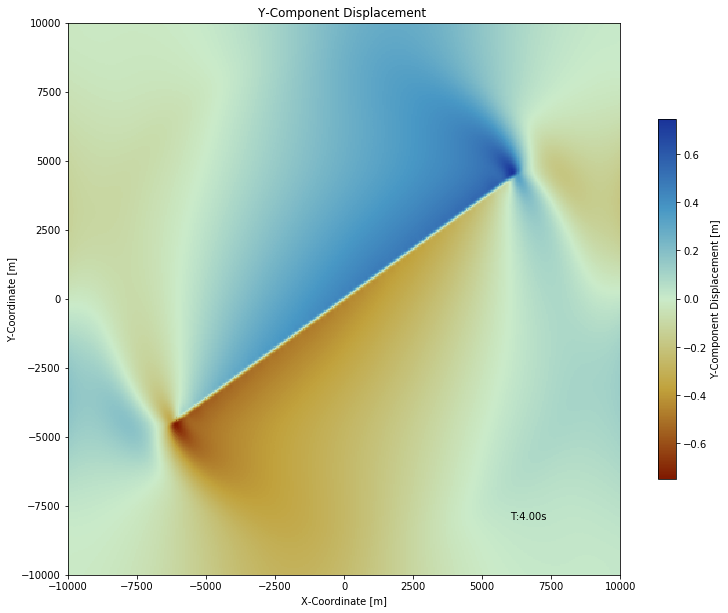

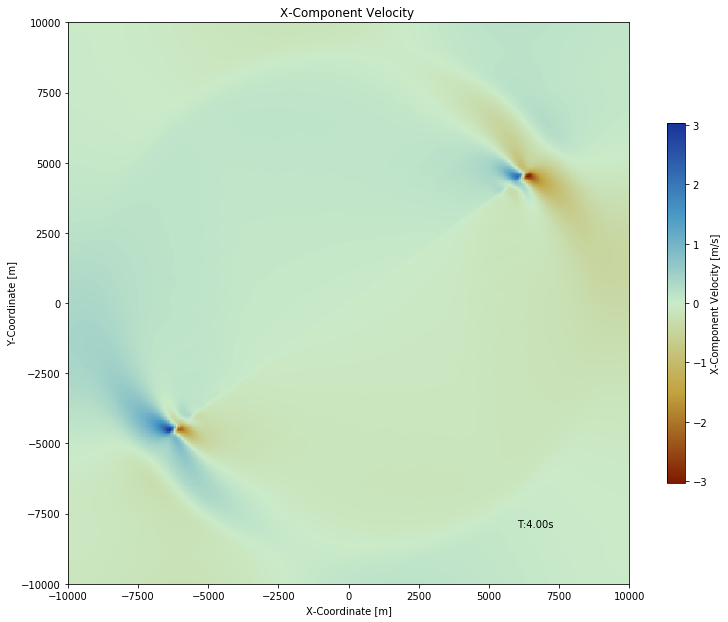

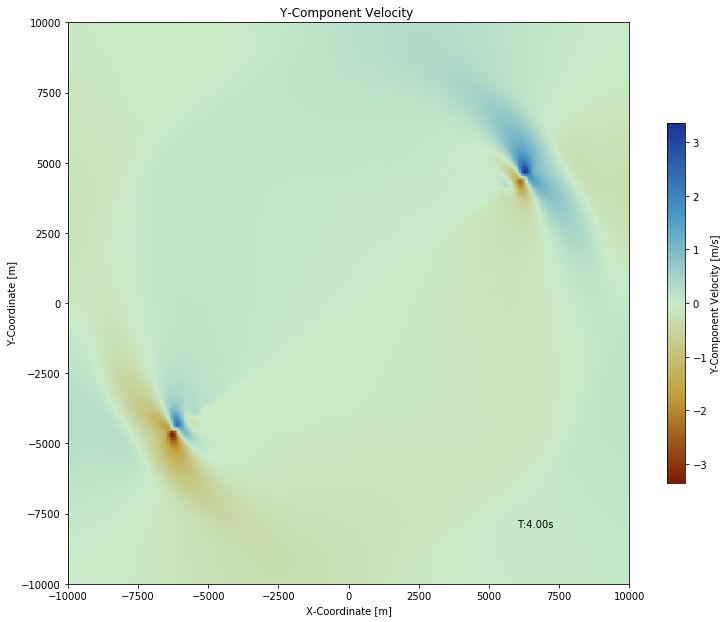

In [14]:
start_time = time.time()

fname = "step-{timestep:04}_wavefield.pbin"

path = "/home/nico/Documents/TEAR/Codes_TEAR/PythonCodes/ConferencesFigures/EGU2021/TiltedData/36deg/"


i=1130
FieldFilename = os.path.join(path,fname.format(timestep=i))

MeshFilename = os.path.join(path, "default_mesh_coor.pbin")
se2_coor = se2wave_load_coordinates(MeshFilename)

TimeStepVal, LCoorX, LCoorY, LFieldX, LFieldY, LFieldvelX, LFieldvelY =  ExtractFields(FieldFilename, se2_coor)

F1,Im1,ax1 = PlotDomain(LCoorX, LCoorY, LFieldX, 
           ["X-Component Displacement ", "X-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F2,Im2,ax2 = PlotDomain(LCoorX, LCoorY, LFieldY, 
           ["Y-Component Displacement ", "Y-Component Displacement [m]"],
           TimeStepVal,cmap=cmap)
F3,Im3,ax3 = PlotDomain(LCoorX, LCoorY, LFieldvelX, 
           ["X-Component Velocity ", "X-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
F4,Im4,ax4 = PlotDomain(LCoorX, LCoorY, LFieldvelY, 
           ["Y-Component Velocity ", "Y-Component Velocity [m/s]"],
           TimeStepVal,cmap=cmap)
